In this notebook, I have tested the performance of a [Vision Transformer](https://arxiv.org/pdf/2010.11929.pdf) on the [ImageWoof](https://github.com/fastai/imagenette#imagewoof) dataset. 

I have used a pretrained ViT - Large model, with 24 layers and 307M parameters, and have fine - tuned as well as evaluated it on the ImageWoof dataset. 

I have also customized the ViT - Large model, that can be used in case it is required to freeze some parts of the model (please see the custom_ViT() function in the Model (4th) section). 

I have used [fastai](https://docs.fast.ai) for this project.

# 1. **Installing and importing the dependencies**

In [ ]:
!pip install fastai timm nbdev -q --upgrade

     |████████████████████████████████| 186 kB 5.4 MB/s 
     |████████████████████████████████| 376 kB 40.5 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 300 kB/s 


In [ ]:
from fastai.vision.all import *
import torch
import timm
import math
import warnings

# 2. **Downloading the ImageWoof dataset**

In [ ]:
path = untar_data(URLs.IMAGEWOOF)
path.ls()

(#3) [Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/train'),Path('/root/.fastai/data/imagewoof2/noisy_imagewoof.csv')]

# 3. **Data Preprocessing**

Each image in the dataset is first resized to 300 x 300, using the [Resize()](https://docs.fast.ai/vision.augment.html#Resize) class. Then, while training the model on each batch, each image, in the batch, is further reduced to the size of 224 x 224, alongwith normalizing them with Imagenet statistics, using [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) and [Normalize](https://docs.fast.ai/data.transforms.html#Normalize), respectively.

Batch size is set to 8.

In [ ]:
item_tfms = Resize(size = 300)
batch_tfms = [*aug_transforms(size = 224, min_scale = 0.35), Normalize.from_stats(*imagenet_stats)]

In [ ]:
bs = 8

In [ ]:
# From "https://walkwithfastai.com/ImageWoof"
label_to_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

In [ ]:
imagewoof = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      splitter = GrandparentSplitter(valid_name = 'val'),
                      get_y = Pipeline([parent_label, label_to_dict.__getitem__]),
                      item_tfms = item_tfms,
                      batch_tfms = batch_tfms)

In [ ]:
dls = imagewoof.dataloaders(path, bs = bs)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


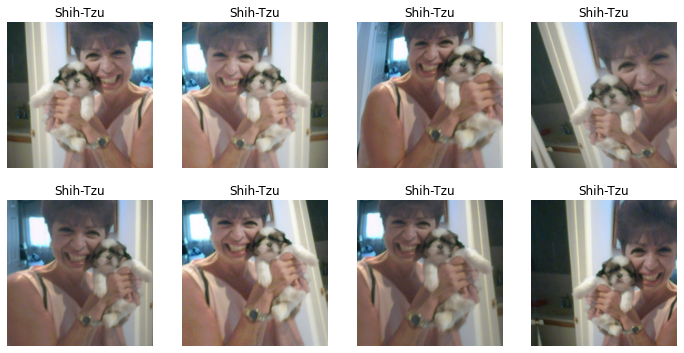

In [ ]:
dls.show_batch(max_n = 9, unique = True)

# 4. **Model**

I have defined a module named EmbedBlock, to concatenate the class token and the input tokens, as well as to add the position embeddings.

In [ ]:
# Heavily inspired by "https://github.com/rwightman/pytorch-image-models/blob/5f9aff395c224492e9e44248b15f44b5cc095d9c/timm/models/vision_transformer.py"

class EmbedBlock (Module) :
  def __init__ (self, num_pathces, embed_dim) :
    self.cls_tokens = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embeds = nn.Parameter(torch.zeros(1, num_pathces + 1, embed_dim))

  def forward (self, x) :
    B = x.shape[0]
    cls_tokens = self.cls_tokens.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim = 1)
    x = x + self.pos_embeds
    return x 

I have also defined a module Header that acts as the final head of our model.

In [ ]:
# Heavily inspired by "https://github.com/rwightman/pytorch-image-models/blob/5f9aff395c224492e9e44248b15f44b5cc095d9c/timm/models/vision_transformer.py"

class Header (Module) :
  def __init__ (self, ni, num_classes) :
    self.head = nn.Linear(ni, num_classes)
  
  def forward (self, x) :
    x = x[:, 0]                  # Extracting the clsass token, which is used for the classification task. 
    x = self.head(x)
    return x

I have defined a custom_ViT() function that wraps the different modules of the model as a sequential object. This is helpful in case it is required to freeze some parts of the model (mostly the body) while, train the other parts (mostly the header).

In [ ]:
def custom_ViT (timm_model_name, num_pathces, embed_dim, ni, num_classes, pretrained = True) :
  model = timm.create_model(timm_model_name, pretrained) 
  module_layers = list(model.children())
  return nn.Sequential(
      module_layers[0],
      EmbedBlock(num_pathces, embed_dim),
      nn.Sequential(*module_layers[1:-1]),
      Header(ni, num_classes)
  ) 

In [ ]:
model_test = custom_ViT('vit_large_patch16_224', 196, 1024, 1024, dls.c, True)

In [ ]:
# Heavily inspired by "https://github.com/rwightman/pytorch-image-models/blob/5f9aff395c224492e9e44248b15f44b5cc095d9c/timm/models/vision_transformer.py"

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(layer, param, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    tensor = layer.get_parameter(param)
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

The trunc_normal_() function, defined above, is used to intialise the parameters of EmbedBlock. 

In [ ]:
# apply_init(model_test[1], lambda x: trunc_normal_(x, param = 'cls_tokens', std = 0.2))
# apply_init(model_test[1], lambda x: trunc_normal_(x, param = 'pos_embeds', std = 0.2))
trunc_normal_(model_test[1], 'cls_tokens')
trunc_normal_(model_test[1], 'pos_embeds')
apply_init(model_test[3], nn.init.kaiming_normal_) 

Checking if the parameters of the EmbedBlock are initialised :

In [ ]:
model_test[1].get_parameter('pos_embeds')

Parameter containing:
tensor([[[-0.7658, -0.6639,  0.3014,  ..., -0.5585,  0.4062,  1.1380],
         [ 0.2405, -0.7484,  0.2357,  ...,  0.8404, -0.3542,  0.7011],
         [ 0.4528,  1.2755, -1.0984,  ...,  0.0114,  0.9454,  0.2197],
         ...,
         [ 0.3010, -0.5402, -0.1533,  ...,  0.0206,  0.7534, -1.4816],
         [-0.7556, -0.0410,  1.1369,  ...,  0.3798,  0.4315,  0.3798],
         [ 0.3351, -0.3292, -1.8016,  ..., -0.3363,  1.3078,  0.4872]]],
       requires_grad=True)

In [ ]:
model_test[1].get_parameter('cls_tokens')

Parameter containing:
tensor([[[-0.1767, -0.3756, -1.0300,  ...,  0.1138,  0.0256,  0.3357]]],
       requires_grad=True)

In [ ]:
# def ViT_split (m) : return L(model_test[0], model_test[1], model_test[2], model_test[3]).map(params)

In the code cell above, I have commented out the code for splitting the model. This is because the ImageWoof dataset is significantly complex. So, in order to increase the capacity of the model, I shall unfreeze the full model.

In [ ]:
learn = Learner(dls, model_test, loss_func = LabelSmoothingCrossEntropy(), metrics = accuracy).to_fp16()

Sumary of the model :

In [ ]:
# learn.freeze()
learn.summary()

Sequential (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 14 x 14  
Conv2d                                    787456     True      
Identity                                                       
EmbedBlock                                                     
Dropout                                                        
LayerNorm                                 2048       True      
____________________________________________________________________________
                     8 x 197 x 3072      
Linear                                    3148800    True      
Dropout                                                        
Linear                                    1049600    True      
Dropout                                                        
Identity                                                       
LayerNorm                                 2048       True      
___________________________________________

I have used [lr_find()](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) method for finding a suitable learning rate.

SuggestedLRs(valley=3.630780702224001e-05)

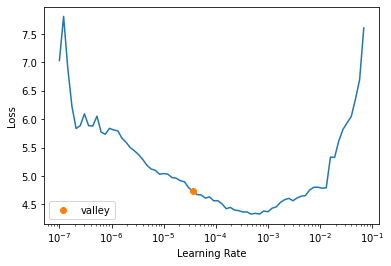

In [ ]:
learn.lr_find()

# 5. **Training and evaluation**

Here, I have trained (fine - tuned) the model for 2 epochs using the [fit_one_cycle()](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle) method.

In [ ]:
learn.fit_one_cycle(2, lr_max = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.553760,1.470484,0.562739,1:10:59
1,1.033532,0.953381,0.812930,1:10:55


So, the accuracy after fine - tuning for 2 epochs is 81.29%

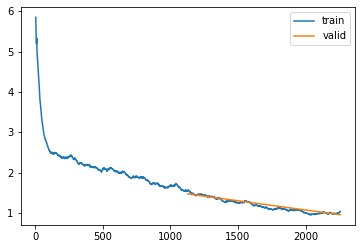

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

The confusion matrix :

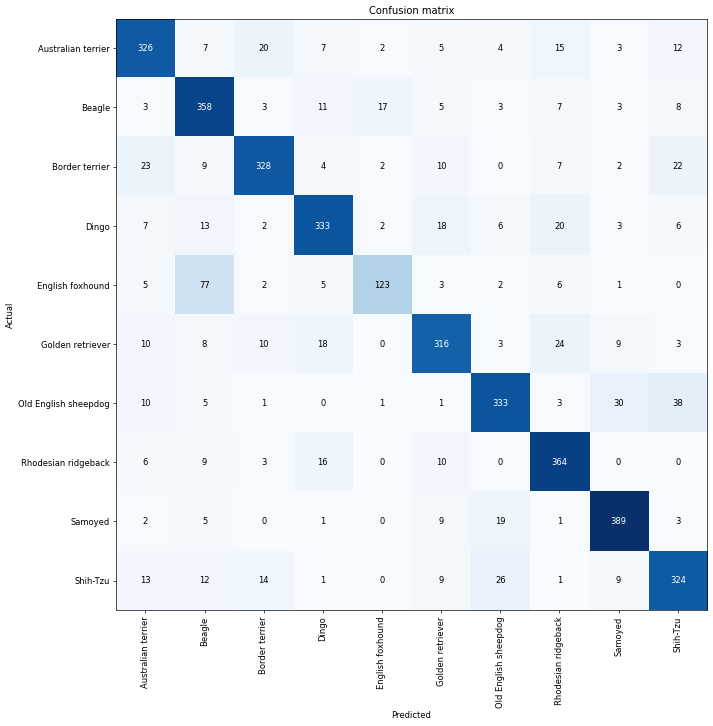

In [ ]:
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

In [ ]:
interp.most_confused(min_val = 20)

[('English foxhound', 'Beagle', 77),
 ('Old English sheepdog', 'Shih-Tzu', 38),
 ('Old English sheepdog', 'Samoyed', 30),
 ('Shih-Tzu', 'Old English sheepdog', 26),
 ('Golden retriever', 'Rhodesian ridgeback', 24),
 ('Border terrier', 'Australian terrier', 23),
 ('Border terrier', 'Shih-Tzu', 22),
 ('Australian terrier', 'Border terrier', 20),
 ('Dingo', 'Rhodesian ridgeback', 20)]

Even now, the model makes a lot of mistakes, and is highly confused with English foxhound, predicting 77 of them as Beagle. I might want to train it longer with the existing augmentations, and then might assess the effects of other augmentations as well as different optimizers.

# 6. **Saving the weights of the model**

In [ ]:
learn.save('stage - 1')

Path('models/stage - 1.pth')

Thanks a lot for taking the time to go through this notebook !
